# Australian magnetic intensity

Here I am going to show you how to make a map of magnetic intensity using 2 different datasets and various masks. The data for the Australian continent came from tiles from the AuScope data portal which I downloaded one day and stitched together with an open-source geotiff tool.

We'll use that dataset in conjunction with the global magnetic dataset that we downloaded from the 0-Preliminaries.md notebook. If you did not already do this, then please, go back, run the notebook and download all the files that we need.

In [1]:
%pylab inline
from osgeo import gdal
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
from cloudstor import cloudstor
teaching_data = cloudstor(url="L93TxcmtLQzcfbk", password='')

teaching_data.download_file_if_distinct("EMAG2_image_V2_no_compr.tif", "Resources/EMAG2_image_V2_no_compr.tif")
teaching_data.download_file_if_distinct("AusMagAll.tiff", "Resources/AusMagAll.tiff")

Cloudstore connection established


Remote and local file size both 147.72 MB, skipping - Resources/EMAG2_image_V2_no_compr.tif


Remote and local file size both 97.37 MB, skipping - Resources/AusMagAll.tiff


In [3]:
base_projection   = ccrs.PlateCarree() 
globalmag         = gdal.Open("Resources/EMAG2_image_V2_no_compr.tif")
globalmag_img     = globalmag.ReadAsArray().transpose(1,2,0)
del(globalmag)

In [4]:
# High resolution total magnetic intensity image map for Australia's land mass (with background masked)

austmag      = gdal.Open("Resources/AusMagAll.tiff")
austmag_img  = austmag.ReadAsArray().transpose(1,2,0)    

## Note that we can use the metadata to find the span of the data in the image

trans =  austmag.GetGeoTransform()
austmag_extent = [trans[0], trans[0] + austmag.RasterXSize*trans[1],
                  trans[3] + austmag.RasterYSize*trans[5], trans[3]]

print( austmag_extent)
print( austmag_img.shape)
print( austmag_img.T.shape)

# Mask out (alpha=0.0) areas with no information (blank = white)

red, green, blue, alpha = austmag_img.T  # Temporarily unpack the bands for readability
blank_areas = (red == 255) & (blue == 255) & (green == 255)
austmag_img[...,3][blank_areas.T] = 0

del(austmag)

[108.0, 160.9989658738366, -46.001727115716754, -5.0]
(4748, 5125, 4)
(4, 5125, 4748)


/usr/share/miniconda3/envs/jupyter/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


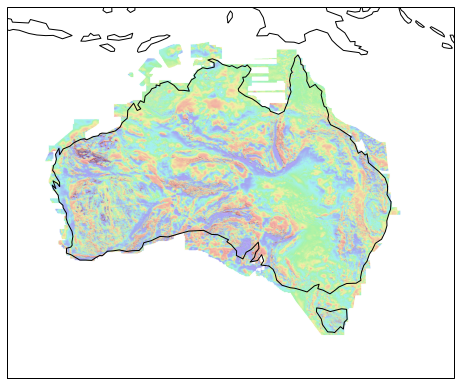

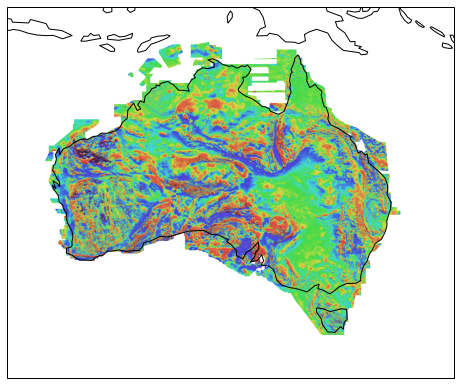

In [5]:
# And here it is ... 

fig = plt.figure(figsize=(8, 10), facecolor="none")
ax  = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(austmag_extent)
plt.imshow(austmag_img, zorder=0, transform=ccrs.PlateCarree(), extent=austmag_extent)
ax.coastlines(color="Black", zorder=1)  
plt.show()


# This one is a bit flat, but we can boost the contrast 
# (either channel by channel or all with the same N)

N = 3.0
austmag_img[...,0] = 255 * (austmag_img[...,0] / 255.0)**N
austmag_img[...,1] = 255 * (austmag_img[...,1] / 255.0)**N 
austmag_img[...,2] = 255 * (austmag_img[...,2] / 255.0)**N 


fig = plt.figure(figsize=(8, 10), facecolor="none")
ax  = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(austmag_extent)
plt.imshow(austmag_img, zorder=0, transform=ccrs.PlateCarree(), extent=austmag_extent)
ax.coastlines(color="Black", zorder=1)  
plt.show()

# Try changing N !

## Features

We already used the ``coastlines`` command, but this is actually a special case of how we add *features* to our maps. Features can be things like rivers or roads, towns, political boundaries. There is a web service called [Natural Earth](http://www.naturalearthdata.com/features/) where you can download this information. Cartopy provides functions to grab this information without having to construct the URL by hand. The only problem is that you still need to know what stuff you can grab. Here are some examples though, and you can see how to choose a resolution for the information which is useful for zoomed in or zoomed out maps.

In [6]:
# "Features" such as land, ocean, coastlines (50m =  the 1:50 million scale)

import cartopy.feature as cfeature

land = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                           edgecolor="green",
                           facecolor="white")

ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '50m',
                           edgecolor="green",
                           facecolor="blue")

coastline = cfeature.NaturalEarthFeature('physical', 'coastline', '50m',
                           edgecolor=(1.0,0.8,0.0),
                           facecolor="none")

# Add these to the plot object as
# ax.add_feature(coastline, linewidth=4, edgecolor=(1,0,1), zorder=1)
# and so forth. zorder is used to force the layering as required.

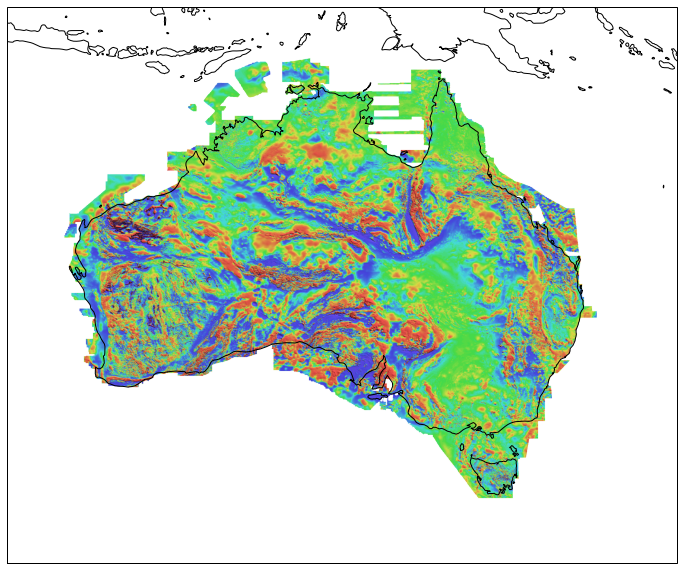

In [7]:
fig = plt.figure(figsize=(12, 12), facecolor="none")
ax  = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(austmag_extent)
plt.imshow(austmag_img, zorder=0, transform=ccrs.PlateCarree(), extent=austmag_extent)
ax.add_feature(coastline, linewidth=1, edgecolor="Black", zorder=1)
plt.show()

Now let us add the global (lower resolution) dataset in the background, mask things up and add coastlines

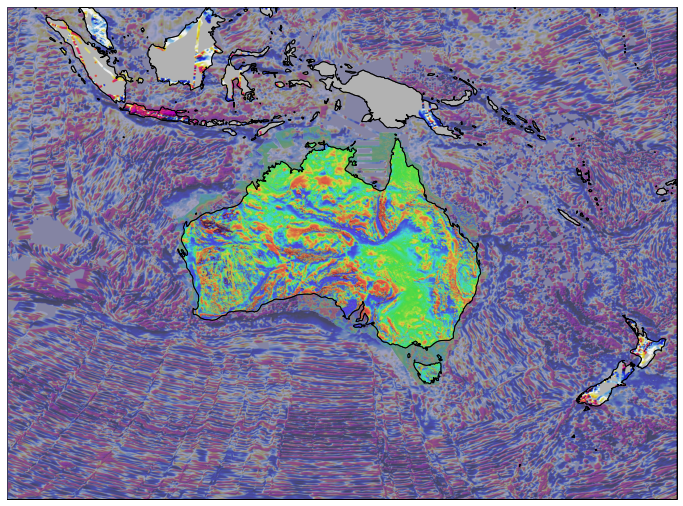

In [8]:
projection = ccrs.PlateCarree()
base_projection = ccrs.PlateCarree()
global_extent     = [-180.0, 180.0, -90.0, 90.0]

fig = plt.figure(figsize=(12, 12), facecolor="none")
ax = plt.axes(projection=projection)
ax.set_extent([90, 180, -50, 5])

ax.imshow(globalmag_img, origin='upper', transform=base_projection, extent=global_extent, zorder=0)
# ax.add_feature(land, facecolor="red", edgecolor="red", alpha=0.1, linewidth=0.5, zorder=1)
ax.add_feature(ocean, facecolor=(0.4,0.4,0.6), edgecolor=(0.0,0.0,0.0), linewidth=1, alpha=0.6, zorder=3)
ax.imshow(austmag_img, origin='upper', transform=base_projection, extent=austmag_extent, zorder=2)
ax.add_feature(coastline, edgecolor="black", linewidth=1, zorder=3)

plt.show()